# Expense tracking with a twist 💸 - ETL (Sort of it)

<br />

<center>
<img src="https://pas-wordpress-media.s3.amazonaws.com/content/uploads/2016/05/15090531/how-to-create-an-expense-budget.jpg" alt="25746" border="0" width="70%" height="70%">
</center>

## Skills: Python, Shell Scripting, Pandas, Matplotlib

Available on [GitHub](https://nico-mori.github.io)

<a id='content' />

## Contents

1. [Introduction](#intro)
2. [Process overview](#overview)
3. [Data Processing](#processing)
4. [Data Analysis](#analysis)

<a id='intro' />

## Introduction
[(back to top)](#content)

Keeping track of one's expenses can be challenging for many people. Some use a spreadsheet, others (the biggest part) an app and there even are the ones that choose to go old school and write down their expenses on paper. 

While I spent most of my years as a university student using and evolving my own spreadsheet (with a quite detailed dashboard), lately I realised that I was getting tired of having to turn on my computer everytime I wanted to register a new expense or check my spending habits. The more inmediate solution was to use a mobile app, but I wasn't able to find one that allowed me the flexiblity that my good old spreadhseet had. 

After a couple weeks I decided that I was going to build my own solution. I would use an app to register the expenses (the most tedious part of regarding the use of the spreadsheet) and then automate the process of generating an expenses report. 



<a id='overview' />

## Process overview
[(back to top)](#content)

The whole process was thought considering simplicity as a key factor. It was essential that the report could be generated with less than 10 clicks. 

The app I used to register my spending was [Splitwise](https://www.splitwise.com). I choosed it because I frequently have to split different bills with friends and family (which is the main goal of the app) and they can be assigned to a wide variety of categories, so the only thing I needed to do was to start using it also for my personal expenses.

The app offers the possibily to export the expenses to a CSV file, the raw data that I would use to generate the report, along with my custom categories (custom_cat.csv). The data is processed using a python script, which is run using a bash script. In order to generate the report I just have to put the csv files in a folder (rawdata) and run the bash script (report_generator.sh), which can be done with a few clicks.

The report has two parts:

1. Summary: a chart and a table with a summary of the expenses by month and category.
2. Detail: a csv file with the amount, the date and the custom category of each expense, in case I want to make further analysis. It can also can be used as a backup in case I ever have problems with the app.

<center>
<img src="https://docs.google.com/drawings/d/e/2PACX-1vT3f6H9QfQqLRR0bv_vgrWd4xBcpJVTEAgtQZWjJsBG8fD-7jncq9TNpi7kLSKN4u1bXXVpXR_kgXYX/pub?w=1109&h=615" alt="25746" border="0" width="50%" height="50%">
</center>

<a id='processing' />

## Data Processing
[(back to top)](#content)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime

Since I split bills with different groups of people, I have to export multiple csv files from splitwise, that non always have the same format. So the first step is to combine all the files into a single dataframe with the same format. 

In [15]:
filepaths = [f for f in os.listdir("./rawdata") if f.endswith('.csv')]
my_name = 'Nicola Mori'

df = pd.DataFrame()

for i in filepaths:

    temp = pd.read_csv('rawdata/'+i)

    #Remove unnecesary rows
    temp = temp[:-1]
    temp = temp[temp['Categorie']!='Pagamento']

    #Unified criteria for ammount column
    temp['Costo'] = pd.to_numeric(temp['Costo'])
    temp['Costo']=np.select([temp[my_name]>0, abs(temp.iloc[:,5:]).sum(axis=1)==0, temp[my_name]<0],
                            [temp['Costo']+temp.iloc[:,5:].drop(columns=[my_name]).sum(axis=1), temp['Costo'], abs(temp[my_name])], 
                            default=0)

    #Keep relevant columns
    temp = temp.loc[:,:'Costo']

    #Append to df
    df = pd.concat([df, temp], ignore_index=True)

#Reformat df
df['Costo'] = df['Costo'].round(2)
df['Data'] = pd.to_datetime(df['Data']).dt.to_period('M') #We are interested only on the month
df = df[['Costo','Data','Descrizione','Categorie']].sort_values(['Data'])

#Keep data for the last 12 months
df = df[df['Data']>=(datetime.now().date() - pd.DateOffset(months=12)).to_period('M')]

Then I merge the dataframe with my own custom categories, so that I can have a more detailed analysis of the expenses. Splitiwse offers 36 detailed categories within 6 general categories. In my case I opted to use my own general categories (Food, House, Health & Career, Shopping and Transport) and kept the detailed ones unmodified.

In [16]:
categories = pd.read_csv('extras/custom_cat.csv', sep=';')

#Merge and drop irrelevant columns
df_cat = df.merge(categories, on='Categorie', how='left')
df_cat = df_cat.drop(['Categorie','Gruppi'], axis=1)

<a id='analysis' />

## Data Analysis
[(back to top)](#content)

After the data was processed and the dataframe with every categorized expense was ready, I faced the problem of getting an idea of the situacion of my expenses with a quick look. 

In first place I grouped the expenses by month and category. Then tested a couple of layouts to see which would be more suitable to present the data. I chose a stacked bar chart with a table on the bottom to see the exact ammount of the grouped expenses.

In [17]:
#Top spenders by month
df_topn =(df_cat[(df_cat.Categoria!='Mangiare') & (~df_cat.Descrizione.isin(['Affitto','Crossfit']))]
    .sort_values(by=['Data','Costo'], ascending=[False,False])
    .groupby('Data')
    .head(5)
    .drop(columns=['Categoria'])
    )

today=str(datetime.now().date())

with open(f'top_spenders_{today}.txt', 'w') as f:
    
    for i in df_topn['Data'].unique():
        f.write(f'Top purchases {i}:\n')
        f.write(df_topn[df_topn['Data']==i].drop(columns=['Data']).to_string(index=False, header=False))
        f.write('\n\n')

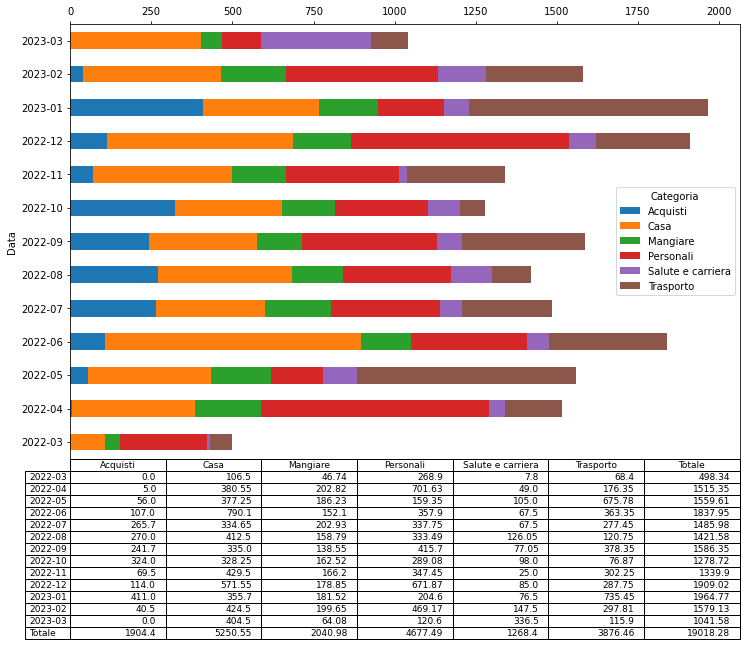

In [18]:
#Group expenses by category and month
df_summ = df_cat.groupby([df_cat.Data, df_cat.Categoria])['Costo'].sum()
df_summ = df_summ.unstack('Categoria')

df_summ = df_summ.fillna(0)

#Add total column and row
df_summ['Totale'] = df_summ.sum(axis=1)
df_summ.loc['Totale'] = df_summ.sum(axis=0)

#Generate plot
fig, ax = plt.subplots(1, 1)
ax.xaxis.tick_top() 

df_summ.iloc[:-1,:-1].plot.barh(stacked=True, figsize=(12,8), table=np.round(df_summ, 2), ax=ax)
#plt.subplots_adjust(left=0, bottom=0)

#Save graph and categorized expenses
today=str(datetime.now().date())

plt.savefig(fname=f'expenses_summary_{today}.png', dpi=300, facecolor='white', bbox_inches='tight')
df_cat.to_csv(f'expenses_detail_{today}.csv', sep=';', index=False)

Finally, I saved the dataframe as a csv file and the chart as a png file. And to orchestrate everything, I created the bash script that would run the python scrip

```` bash
python3 folder_path/expenses_report.py
````